# **Notebook 3: Feature Engineering**

## Objectives

* Generate train and test sets for feature engineering.
* Engineer features for Classification, Regression and Cluster models

## Inputs

* outputs/datasets/cleaned/house_prices_records_cleaned.csv

## Outputs

* Generate Train and Test sets from cleaned data, saved under outputs/datasets/cleaned/train and outputs/datasets/cleaned/test

## Comment

* For readers of this notebook, previously the name of the main dataframe used in this project has been called 'records_df'. From this notebook on, the main dataframe will simply be 'df'. In this notebook, we split df into train and test sets, and their respective names will reflect this also.



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/housing/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/housing'

# Load data

In [6]:
import pandas as pd
df_raw_path = "outputs/datasets/cleaned/house_prices_records_cleaned.csv"
df = pd.read_csv(df_raw_path)
df.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854,3,No,706,GLQ,150,548,RFn,2003,...,8450,65,196,61,5,7,856,2003,2003,208500
1,1262,0,3,Gd,978,ALQ,284,460,RFn,1976,...,9600,80,0,0,8,6,1262,1976,1976,181500
2,920,866,3,Mn,486,GLQ,434,608,RFn,2001,...,11250,68,162,42,5,7,920,2001,2002,223500


# Split train and test data

In the cell below, the target variable 'SalePrice' is separated out from the rest of the data, and the split produces both a train and test set for the features (TrainSet and TestSet) and the target (train_target and test_target).

The reason for changing the code from the walkthrough is that in the train_test_split() function, I was passing df('SalePrice') as the target variable, but also including it in my df, which means my target variable 'SalePrice' would be present in both my features and targets, which is not what I would typically want.

In [ ]:
from sklearn.model_selection import train_test_split

features = df.drop('SalePrice', axis=1)  # drop the target variable from the feature set
target = df['SalePrice']

TrainSet, TestSet, train_target, test_target = train_test_split(
    features,
    target,
    test_size=0.2,
    random_state=0
)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")


As we see in the output, the train set has 1168 rows which is 80% of the data, and the test set accounts for the remaining 20%.

We then save the train and test set respectively in their folders.

In [ ]:
TrainSet.to_csv("outputs/datasets/cleaned/train/TrainSetCleaned.csv", index=False)
TestSet.to_csv("outputs/datasets/cleaned/test/TestSetCleaned.csv", index=False)

And we also save the datasets where we put the target variable.

In [ ]:
train_target.to_csv("outputs/datasets/cleaned/train/TrainSetTarget.csv", index=False)
test_target.to_csv("outputs/datasets/cleaned/test/TestSetTarget.csv", index=False)

# Correlation and PPS Analysis

Note: Since the first notebooks in this project are not identical to those of the walkthrough project Churnometer, namely we did data cleaning before the EDA and analyses (which is a valid approach), we will therefore assess correlation levels and PPS here before starting the feature engineering process.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

Calculate Correlations and Power Predictive Score

In [8]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  462.0  0.061  0.105  0.0  0.0  0.0  0.083  0.625


What does this mean? 
- count: There are 462 pairs of variables for which the PPS was calculated.
- mean: On average, the PPS among all the pairs is around 0.061. This indicates that, on average, variables have a relatively weak predictive power.
- std: The standard deviation is 0.105, which indicates a relatively large variation in the PPS scores across different pairs of variables.
- min: The lowest PPS score among all pairs is 0. This means that for at least one pair, there is no predictive power from one variable to another.
- 25% (1st Quartile): 25% of the pairs have a PPS of 0.
- 50% (Median): Half of the pairs have a PPS of 0. This indicates that for most variable pairs, there's no predictive power or it's very weak.
- 75% (3rd Quartile): 75% of the pairs have a PPS up to 0.083. This further demonstrates that the majority of variable pairs have very low predictive power.
- max: The highest PPS score among all pairs is 0.625. This means that there is at least one pair of variables where one variable can predict the other with a fair amount of accuracy (62.5%).

The output suggests that most pairs of variables have very low or no predictive power, but there are few pairs with relatively high predictive power (max PPS is 0.625).

Therefore we display at heatmaps to help visualize the relationship among different variables in the dataset. Note the relatively high thresholds set as the maps become difficult to read when all moderately correlated variables are shown.

In [9]:
%matplotlib inline



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



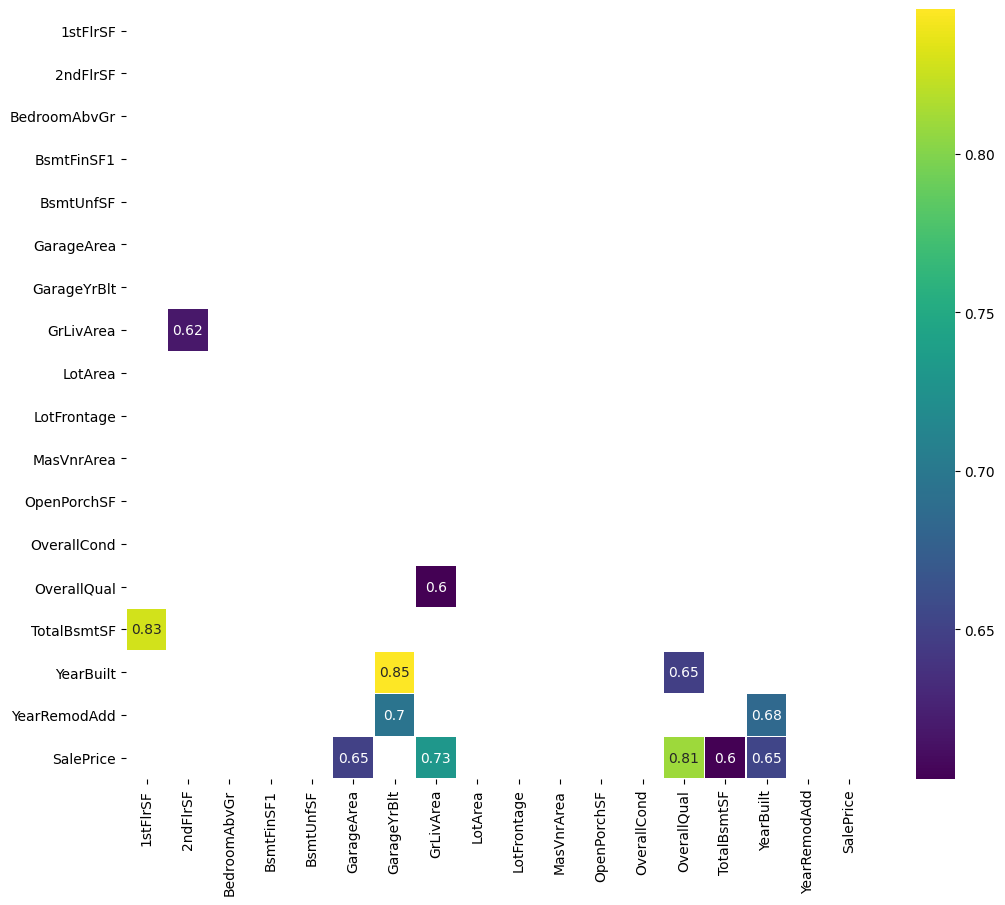



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



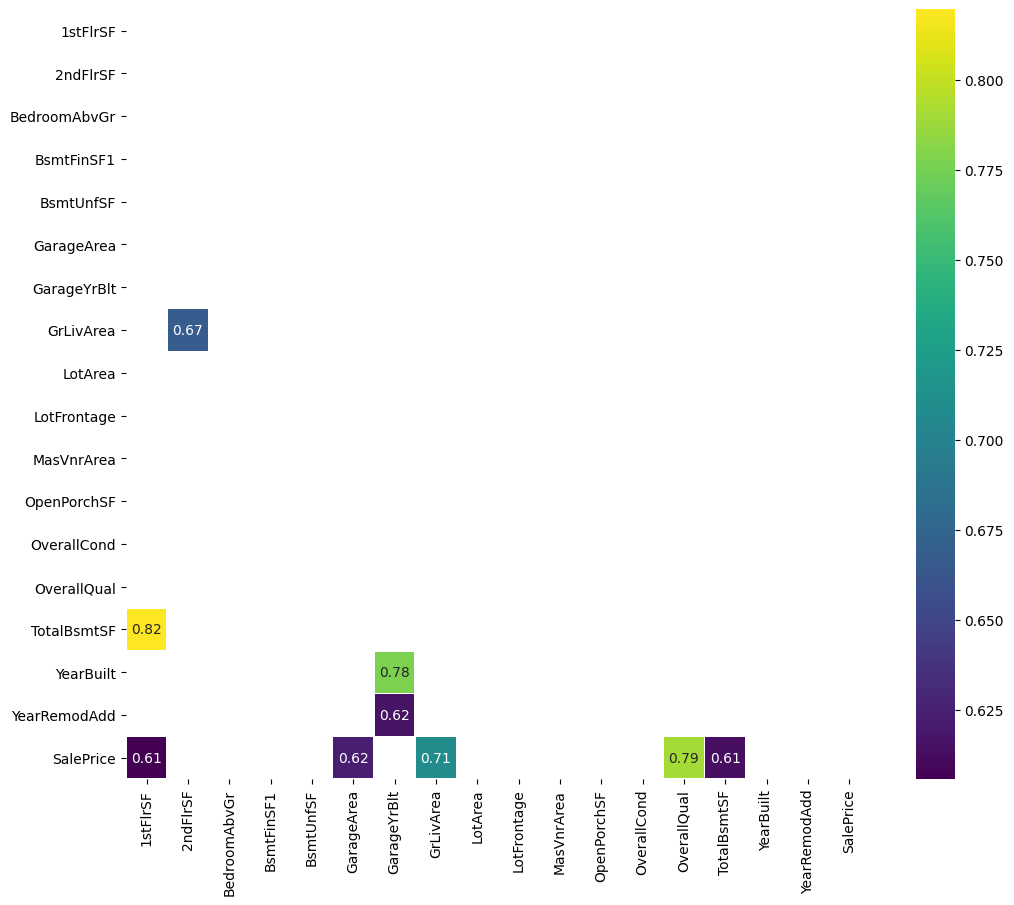



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



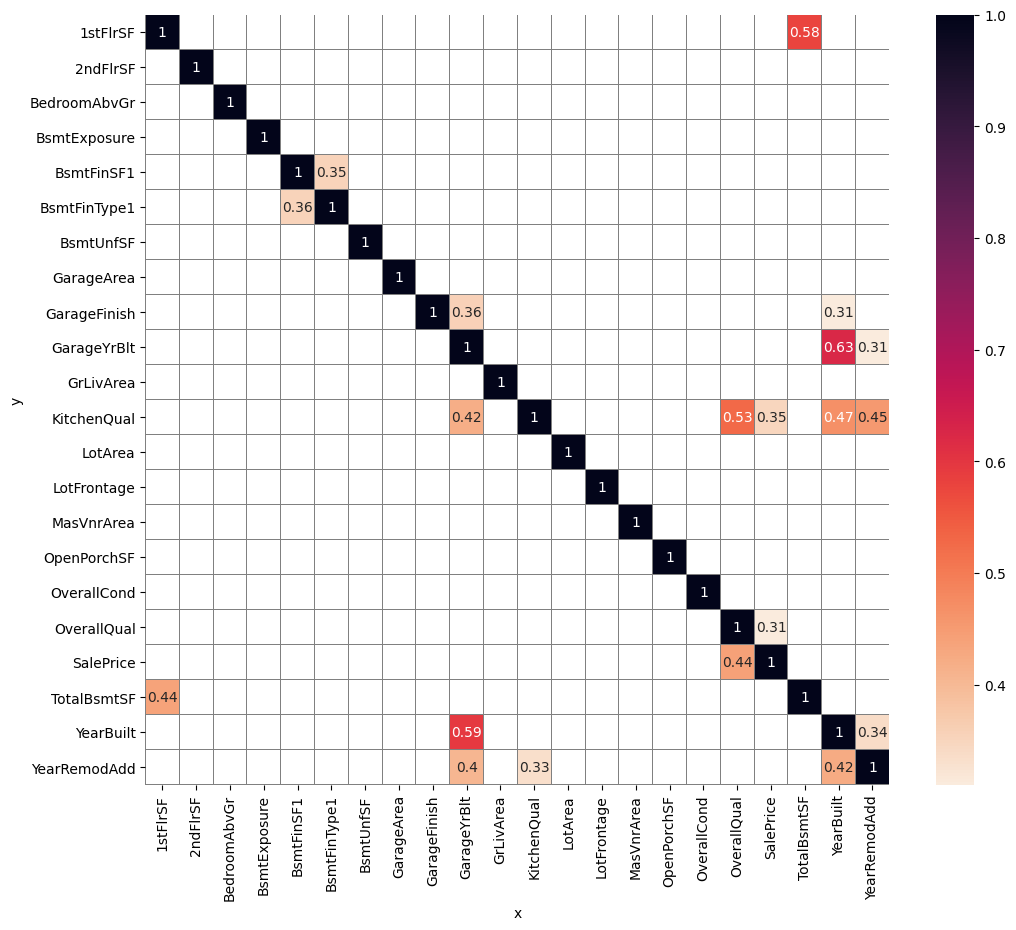

In [13]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.6, PPS_Threshold =0.3,
                  figsize=(12,10), font_annot=10)

A couple of observations from the heatmaps:
- 'TotalBsmtSF' and '1stFlrSF':
These variables are highly correlated with each other as shown by their high Spearman (0.83) and Pearson scores (0.82). This means that they tend to increase or decrease together. For example, a larger basement ('TotalBsmtSF') often comes with a larger first floor ('1stFlrSF'). Their Power Predictive Score (PPS) of 0.44 indicates a moderate predictive power. In other words, knowledge of 'TotalBsmtSF' would be moderately useful in predicting the value of '1stFlrSF'.

- 'YearBuilt' and 'GarageYrBlt':
Again, these variables are highly correlated, with Spearman (0.85) and Pearsob (0.78). This implies that houses tend to have their garages built the same year as the house itself. The high PPS of 0.59 indicates that the year a house was built ('YearBuilt') is a good predictor of the year its garage was built ('GarageYrBlt'), and vice versa.

The findings suggest that each pair of variables carries similar information, indicating multicollinearity.

# FEATURE ENGINEERING

In this section we are interested to evaluate which potential transformation we could do in our variables.

# Load cleaned training and test sets

In [14]:
import pandas as pd

TrainSet_df = pd.read_csv("outputs/datasets/cleaned/train/TrainSetCleaned.csv")
TestSet_df = pd.read_csv("outputs/datasets/cleaned/test/TestSetCleaned.csv")

# Check the first few rows of the DataFrame to confirm that it loaded correctly
TrainSet_df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
0,2515,0,4,No,1219,Rec,816,484,Unf,1975,...,TA,32668,69,0,0,3,6,2035,1957,1975
1,958,620,3,No,403,BLQ,238,240,Unf,1941,...,Fa,9490,79,0,0,7,6,806,1941,1950
2,979,224,3,No,185,LwQ,524,352,Unf,1950,...,Gd,7015,69,161,0,4,5,709,1950,1950
3,1156,866,4,No,392,BLQ,768,505,Fin,1977,...,TA,10005,83,299,117,5,7,1160,1977,1977
4,525,0,3,No,0,Unf,525,264,Unf,1971,...,TA,1680,21,381,0,5,6,525,1971,1971


# Feature Engineering Analysis

Custom function:

In [15]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type='numerical'):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like pandas-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

# Push files to Repo

* If you do not need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
